In [1]:
#install pytorch-ignite to get the metrics 
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 5.8 MB/s 


In [ ]:
# importing all the required libraries
import os
import cv2
import glob
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from ignite.metrics.confusion_matrix import ConfusionMatrix
from ignite.metrics import mIoU, IoU

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import random
from random import randint
from torch import optim

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Prepare Dataset

In [ ]:
#mounting google drive to access the dataset 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#loading training and validation datasets, test dataset doesn't have annotations so we will use split traning data into train and test data
train_label_data_path  = '/content/gdrive/MyDrive/DL dataset/gtfine/gtFine_trainvaltest/gtFine/train'
valid_label_data_path  = '/content/gdrive/MyDrive/DL dataset/gtfine/gtFine_trainvaltest/gtFine/val'
train_img_path  = '/content/gdrive/My Drive/DL dataset/leftimg/leftImg8bit/leftImg8bit/train'
valid_img_path  = '/content/gdrive/My Drive/DL dataset/leftimg/leftImg8bit/leftImg8bit/val'

In [ ]:
train_labels = sorted(glob.glob(train_label_data_path+"/*/*_labelIds.png"))
valid_labels = sorted(glob.glob(valid_label_data_path+"/*/*_labelIds.png"))
train_inp = sorted(glob.glob(train_img_path+"/*/*.png"))
valid_inp = sorted(glob.glob(valid_img_path+"/*/*.png")) 

In [ ]:
from collections import namedtuple

## from labels.py file
# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [ ]:
# labels that will be used has ignoreinEval == False
labels_used = []
ids = []
for i in range(len(labels)):
  # if labels[i].name == 'unlabeled':
  #   labels_used.append(labels[i])
  if(labels[i].ignoreInEval == False):
    labels_used.append(labels[i])
    ids.append(labels[i].id)
print("number of labels used = " + format(len(labels_used )))

number of labels used = 19


In [ ]:
label_in = cv2.imread(train_labels[0])[:,:,0]#visualize a sample label

In [ ]:
#create a dictionary with label_id as key & train_id as value
label_dic = {}
for i in range(len(labels)-1):
  label_dic[labels[i].id] = labels[i].trainId

In [ ]:
#function to convert labelids to trainids
def createtrainID(label_in,label_dic):
  mask = np.zeros((label_in.shape[0],label_in.shape[1]))
  l_un = np.unique(label_in)
  for i in range(len(l_un)):
    mask[label_in==l_un[i]] = label_dic[l_un[i]] 
  return mask

In [ ]:
#function to visualize the labels
def visual_label(mask,labels_used,plot = False):
  label_img = np.zeros((mask.shape[0],mask.shape[1],3))
  r = np.zeros((mask.shape[0],mask.shape[1]))
  g = np.zeros((mask.shape[0],mask.shape[1]))
  b = np.zeros((mask.shape[0],mask.shape[1]))
  l_un = np.unique(mask)
  for i in range(len(l_un)):
    if l_un[i]<19:
      r[mask==int(l_un[i])] = labels_used[int(l_un[i])].color[0]
      g[mask==int(l_un[i])] = labels_used[int(l_un[i])].color[1]
      b[mask==int(l_un[i])] = labels_used[int(l_un[i])].color[2]
  
  label_img[:,:,0] = r/255
  label_img[:,:,1] = g/255
  label_img[:,:,2] = b/255

  if plot:
    plt.imshow(label_img)
  return label_img

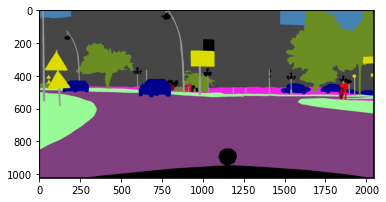

In [ ]:
label_img = visual_label(createtrainID(label_in,label_dic),labels_used,plot = True)

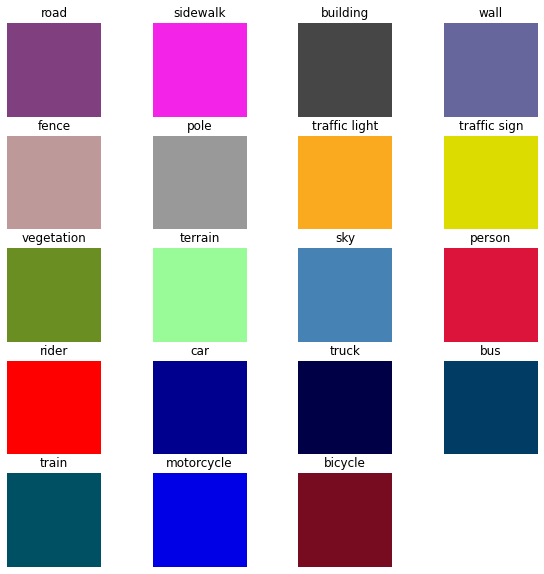

In [ ]:
#description of different colors
fig = plt.figure(figsize = (10,10))

for i in range(len(labels_used)):
    temp = np.zeros((5,5,3))
    temp[:,:,0] = labels_used[i].color[0]/255
    temp[:,:,1] = labels_used[i].color[1]/255
    temp[:,:,2] = labels_used[i].color[2]/255
    ax = fig.add_subplot(5, 4, i+1)
    ax.imshow(temp)
    ax.set_title(labels_used[i].name)
    ax.axis('off')

In [ ]:
#function to generate images for training, validation and testing
def gen_images(x,s1=96,s2=96):
  _,_,s3 = cv2.imread(x[0]).shape
  img = np.zeros((len(x),s1,s2,s3))
  for i in range(len(x)):
      image= cv2.resize(cv2.imread(x[i]),(s1,s2),interpolation = cv2.INTER_NEAREST)
      image = image/255
      img[i,:,:,:] = image
  return torch.tensor(img).permute(0,3,1,2)



In [ ]:
#function to generate images for training, validation and testing
def gen_mask_train(x,label_dic,s1=96,s2=96):
  #s1,s2,_ = cv2.imread(x[0]).shape
  mask = np.zeros((len(x),s1,s2))
  for i in range(len(x)):
      image = createtrainID(cv2.resize(cv2.imread(x[i]),(s1,s2),interpolation = cv2.INTER_NEAREST)[:,:,0],label_dic)
      mask[i,:,:] = image
      mask[mask==255] = 19
  return torch.tensor(mask)

In [ ]:
train = []
train_dataset = []
test_dataset = []
valid_dataset =[]

for x in zip(train_inp,train_labels):
  train.append(x)

for x in zip(valid_inp,valid_labels):
  valid_dataset.append(x)
# train_split_ratio = 0.6
# test_split_ratio = 0.2

# num_samples = len(train)
# train_size = int(num_samples*train_split_ratio)
# test_size = int(num_samples*test_split_ratio)
# val_size = num_samples-train_size-test_size

n =  len(train)
train_n = int(0.8*n) 
np.random.seed(0)
perm = np.random.permutation(n)

for i in range(len(perm[0:train_n])):   
  train_dataset.append(train[perm[i]])
for i in range(len(perm[train_n:n])):
  test_dataset.append(train[perm[i+train_n]])  
# for i in range(len(perm[train_size+test_size:num_samples])):
#   valid_dataset.append(train[perm[i]]) 

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=16, 
                                           shuffle=True, 
                                           num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=16, 
                                           shuffle=True, 
                                           num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=16, 
                                           shuffle=True, 
                                           num_workers=0)

In [ ]:
print ("Training set size: {}".format(len(train_dataset)))
print ("Validation set size: {}".format(len(valid_dataset)))
print ("Test set size: {}".format(len(test_dataset)))

Training set size: 2380
Validation set size: 500
Test set size: 595


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
x,y = iter(train_loader).next()
img = gen_images(x)
img = img.to(device).type(torch.float)
mask = gen_mask_train(y,label_dic)
mask = mask.to(device)

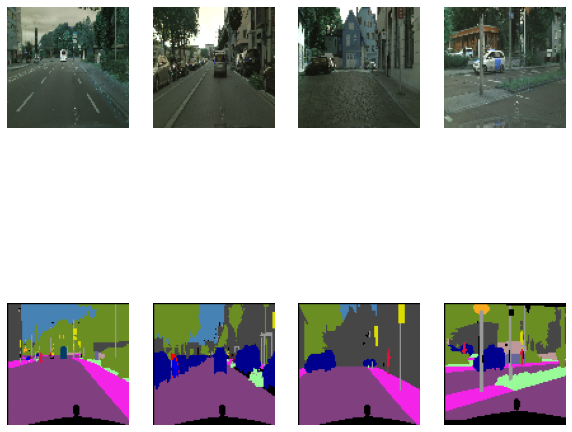

In [ ]:
#visualize some of the training images with labels
n_images = 4

fig = plt.figure(figsize = (10,10))

for i in range(n_images*2):
    ax = fig.add_subplot(2, n_images, i+1)
    if i<n_images:
      ax.imshow(img.permute(0,2,3,1)[i,:,:,:].cpu().numpy())
    else:
      ax.imshow(visual_label(mask[int(i%n_images),:,:].cpu().numpy(),labels_used))
    ax.axis('off')

# Model Development (SegNet)

In [ ]:
#create different operations of the network opearations of the network
# idea from https://github.com/alejandrodebus
'''
First is the single convolution layer.
convulution->batch_norm->relu
'''
class single_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        # Define the layers here
        # Note: for conv, use a padding of (1,1) so that size is maintained
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,padding = 1)
        self.bn = nn.BatchNorm2d(out_ch,momentum = 0.9)
        self.relu = nn.ReLU()
    def forward(self, x):
        # define forward operation using the layers above
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
'''
Second is the maxpool with indicies
'''
class down_layer(nn.Module):
    def __init__(self):
        super(down_layer, self).__init__()
        self.down = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # use nn.MaxPool2d( )        
    def forward(self, x):
        x1,idx = self.down(x)
        return x1,idx

'''
Third is the unpool layer
'''
class un_pool(nn.Module):
    def __init__(self):
        super(un_pool, self).__init__()       
        self.un_pool = nn.MaxUnpool2d(kernel_size=2, stride=2) # use nn.Upsample() with mode bilinear
        
    
    def forward(self, x, idx,x1):
        #Take the indicies from maxpool layer
        x = self.un_pool(x,idx,output_size = x1.size())
        return x 
'''
Last layer is just convolution layer so we just dust define convoulution
for outlayer
'''
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,padding = 1)

    def forward(self, x):
        # Forward conv layer
        x = self.conv(x)
        return x

In [ ]:
# use all above the individual operations to build the network 
class SegNet(nn.Module):
    def __init__(self, n_channels_in, n_classes):
        super(SegNet, self).__init__()
        self.conv1 = single_conv(n_channels_in,64)
        self.conv2 = single_conv(64,64)
        self.down1 = down_layer()
        self.conv3 = single_conv(64,128)
        self.conv4 = single_conv(128,128)
        self.down2 = down_layer()
        self.conv5 = single_conv(128,256)
        self.conv6 = single_conv(256,256)
        self.conv7 = single_conv(256,256)
        self.down3 = down_layer()
        self.conv8 = single_conv(256,512)
        self.conv9 = single_conv(512,512)
        self.conv10 = single_conv(512,512)
        self.down4 = down_layer()
        self.conv11 = single_conv(512,512)
        self.conv12 = single_conv(512,512)
        self.conv13 = single_conv(512,512)
        self.down5 = down_layer()
        self.up1 = un_pool()
        self.conv14 = single_conv(512,512)
        self.conv15 = single_conv(512,512)
        self.conv16 = single_conv(512,512)
        self.up2 = un_pool()
        self.conv17 = single_conv(512,512)
        self.conv18 = single_conv(512,512)
        self.conv19 = single_conv(512,256)
        self.up3 = un_pool()
        self.conv20 = single_conv(256,256)
        self.conv21 = single_conv(256,256)
        self.conv22 = single_conv(256,128)
        self.up4 = un_pool()
        self.conv23 = single_conv(128,128)
        self.conv24 = single_conv(128,64)
        self.up5 = un_pool()
        self.conv25 = single_conv(64,64)
        self.outconv1 = outconv(64,n_classes)

    def forward(self, x):
        # Define forward pass
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3,idx1 = self.down1(x2)
        x4 = self.conv3(x3)
        x5 = self.conv4(x4)
        x6,idx2 = self.down2(x5)
        x7 = self.conv5(x6)
        x8 = self.conv6(x7)
        x9 = self.conv7(x8)
        x10,idx3 = self.down3(x9)
        x11 = self.conv8(x10)
        x12 = self.conv9(x11)
        x13 = self.conv10(x12)
        x14,idx4 = self.down4(x13)
        x15 = self.conv11(x14)
        x16 = self.conv12(x15)
        x17 = self.conv13(x16)
        x18,idx5 = self.down5(x17)
        x19 = self.up1(x18,idx5,x17)
        x20 = self.conv14(x19)
        x21 = self.conv15(x20)
        x22 = self.conv16(x21)
        x23 = self.up2(x22,idx4,x13)
        x24 = self.conv17(x23)
        x25 = self.conv18(x24)
        x26 = self.conv19(x25)
        x27 = self.up3(x26,idx3,x9)
        x28 = self.conv20(x27)
        x29 = self.conv21(x28)
        x30 = self.conv22(x29)
        x31 = self.up4(x30,idx2,x5)
        x32 = self.conv23(x31)
        x33 = self.conv24(x32)
        x34 = self.up4(x33,idx1,x2)
        x35 = self.conv25(x34)
        x = self.outconv1(x35)
        ## Go up back to original dimension
        return x    

In [ ]:
net = SegNet(3,20) #one additional class for pixel ignored

In [ ]:
#count the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(net))

29454548


In [ ]:
LR = 0.0001

In [ ]:
optimizer = torch.optim.Adam(
    net.parameters(),
    lr=LR,weight_decay = .0002,amsgrad=True
)

In [ ]:
#initialize the parameters
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)

In [ ]:
net.apply(initialize_parameters)

SegNet(
  (conv1): single_conv(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): single_conv(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (down1): down_layer(
    (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): single_conv(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv4): single_conv(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (down2): dow

In [ ]:
 weights = np.zeros((20))
 for (_, y) in tqdm(train_loader):
    y = gen_mask_train(y,label_dic)
    y = y.to(device).long()
    for i in range(20):
      weights[i] += torch.sum((y==i).type(torch.uint8))

100%|██████████| 149/149 [25:47<00:00, 10.39s/it]


In [ ]:
# weights = np.median(weights/np.sum(weights))/(weights/np.sum(weights))

In [ ]:
weights = 1./(np.log(1.05+weights/np.sum(weights)))
weights

array([ 3.147, 10.221,  4.46 , 18.311, 17.906, 16.993, 19.82 , 18.757,
        5.695, 17.081, 12.274, 16.995, 20.035,  9.404, 19.683, 19.667,
       19.894, 20.141, 19.124,  6.383])

roup 1 = \{Sky\}, Group 2 = \{ Building, Wall, Fence, Vegetation,Terrain\}, Group 3 = \{Road, Sidewalk, Train\}, Group 4 = \{Pole, Traffic Lightm Traffic Sign, Person, Rider, Car, Truck, Bus, Motorcycle, Bicycle\}

#### Importance Awareness Loss based on https://arxiv.org/pdf/1907.11066v2.pdf

In [ ]:
#dividing into four groups
class_weights1 = np.zeros((20))
class_weights1[10]= weights[10]
class_weights1[19]= weights[19]
class_weights2 = np.zeros((20))
class_weights2[2] = weights[2]
class_weights2[3] = weights[3]
class_weights2[4] = weights[4]
class_weights2[8] = weights[8]
class_weights2[9] = weights[9]
class_weights3 = np.zeros((20))
class_weights3[0] = weights[0]
class_weights3[1] = weights[1]
class_weights3[16] = weights[16]
class_weights4 = np.zeros((20))
class_weights4[5] = weights[5]
class_weights4[6] = weights[6]
class_weights4[7] = weights[7]
class_weights4[11] = weights[11]
class_weights4[12] = weights[12]
class_weights4[13] = weights[13]
class_weights4[14] = weights[14]
class_weights4[15] = weights[15]
class_weights4[17] = weights[17]
class_weights4[18] = weights[18]

In [ ]:
class_weights1 = torch.tensor(class_weights1).float().to(device)
class_weights2 = torch.tensor(class_weights2).float().to(device)
class_weights3 = torch.tensor(class_weights3).float().to(device)
class_weights4 = torch.tensor(class_weights4).float().to(device)

In [ ]:
net = net.to(device)

# Training SegNet on cityscapes dataset

In [ ]:
def IAL(y_pred,y,weights):
  return nn.functional.cross_entropy(y_pred,y,weight = weights)

In [ ]:
#weighted mean IoU to be consistent with cityscapes dataset
def mean_iou(y_pred,y,num_class = 20):
  y1 = torch.argmax(y_pred,dim=1)
  y2 = nn.functional.one_hot(y1,num_classes=num_class).permute(0,3,1,2)
  metric = ConfusionMatrix(num_classes=num_class)
  miou = IoU(metric,ignore_index=num_class-1)
  miou.reset()
  miou.update((y2,y))
  m = miou.compute()
  weights = np.zeros((20))
 
  for i in range(20):
    weights[i] += torch.sum((y==i).type(torch.uint8))
  
  return torch.sum(m*weights[:-1]/np.sum(weights[:-1]))

In [ ]:
# define train epoch
def train(model, iterator, optimizer, device,label_dic):
    
    epoch_loss = 0
    epoch_IoU = 0
    
    model.train()
    
    for (x, y) in tqdm(iterator):
        x = gen_images(x)
        x = x.to(device).type(torch.float)
        y = gen_mask_train(y,label_dic)
        y = y.to(device).long()
        if random.random()<0.5:
          seed =randint(-10,10)
          x = torchvision.transforms.functional.rotate(x,angle=seed)
          y = torchvision.transforms.functional.rotate(y,angle=seed)

        if random.random()<0.5:
          x = torch.flip(x,dims = (0,3))
          y = torch.flip(y,dims = (0,2))
        optimizer.zero_grad()

        # weights = np.zeros((20))
        
        # for i in range(20):
        #   weights[i] += torch.sum((y==i).type(torch.uint8))
        # weights = np.median(weights/np.sum(weights))/(1+weights/np.sum(weights))
        # # weights = 1./(np.log(1.05+weights/np.sum(weights)))
        # #dividing into four groups
        # class_weights1 = np.zeros((20))
        # class_weights1[10]= weights[10]
        # class_weights1[19]= weights[19]
        # class_weights2 = np.zeros((20))
        # class_weights2[2] = weights[2]
        # class_weights2[3] = weights[3]
        # class_weights2[4] = weights[4]
        # class_weights2[8] = weights[8]
        # class_weights2[9] = weights[9]
        # class_weights3 = np.zeros((20))
        # class_weights3[0] = weights[0]
        # class_weights3[1] = weights[1]
        # class_weights3[16] = weights[16]
        # class_weights4 = np.zeros((20))
        # class_weights4[5] = weights[5]
        # class_weights4[6] = weights[6]
        # class_weights4[7] = weights[7]
        # class_weights4[11] = weights[11]
        # class_weights4[12] = weights[12]
        # class_weights4[13] = weights[13]
        # class_weights4[14] = weights[14]
        # class_weights4[15] = weights[15]
        # class_weights4[17] = weights[17]
        # class_weights4[18] = weights[18]
        # class_weights1 = torch.tensor(class_weights1).float().to(device)
        # class_weights2 = torch.tensor(class_weights2).float().to(device)
        # class_weights3 = torch.tensor(class_weights3).float().to(device)
        # class_weights4 = torch.tensor(class_weights4).float().to(device)

                
        y_pred = model(x).float()
        y1 = y_pred.permute(1,0,2,3).reshape(20,-1)
        y1 = nn.functional.softmax(y1,dim = 0)
        y2 = nn.functional.one_hot(y,num_classes=20).permute(3,0,1,2).reshape(20,-1)
        y3 = torch.split(y2,1)
        M1 = y3[0] + y3[1]+ y3[2] + y3[3] +y3[4]+ y3[5]+ y3[6] + y3[7] + y3[8] + y3[9] +y3[11] + y3[12] + y3[13] +y3[14]+ y3[15]+ y3[16] + y3[17] + y3[18] 

        M2 = y3[0]+ y3[1] + y3[5]+ y3[6] + y3[7]  +y3[11] + y3[12] + y3[13] +y3[14]+ y3[15]+ y3[16] + y3[17] + y3[18] 

        M3 =  y3[5]+ y3[6] + y3[7]  +y3[11] + y3[12] + y3[13] +y3[14]+ y3[15]+ y3[16] + y3[17] + y3[18] 
        X = torch.sum(y2*y1,dim=0).reshape(1,-1) 
        f1 = torch.sum(torch.pow(torch.pow(M1+0.5,0.5)*(X-M1),2))/(2*torch.sum(y2))
        f2 = torch.sum(torch.pow(torch.pow(M2+0.5,0.5)*(X-M2)*M1,2))/(2*torch.sum(M1))
        f3 = torch.sum(torch.pow(torch.pow(M3+0.5,0.5)*(X-M3)*M2,2))/(2*torch.sum(M2))
        loss1 = IAL(y_pred,y,class_weights1)
        loss2 = IAL(y_pred,y,class_weights2)
        loss3 = IAL(y_pred,y,class_weights3)
        loss4 = IAL(y_pred,y,class_weights4)

        total_loss = loss1 + loss2*(f1+1)+ loss3*(f1+1)*(f2+1)+ loss4*(f1+1)*(f2+1)*(f3+1)


        IoU = mean_iou(y_pred, y)
        
        total_loss.backward()
        
        optimizer.step()
        
        epoch_loss += total_loss.item()
        epoch_IoU += IoU.item()
        
    return epoch_loss / len(iterator), epoch_IoU/len(iterator)

In [ ]:
def evaluation(model, iterator, device,label_dic):
    
    epoch_loss = 0
    epoch_IoU = 0
    
    model.eval()
    
    with torch.no_grad():
      for (x, y) in tqdm(iterator):
          x = gen_images(x)
          x = x.to(device).type(torch.float)
          y = gen_mask_train(y,label_dic)
          y = y.to(device).long()
          
          y_pred = model(x).float()
          # loss = criterion(y_pred, y)
          # loss = criterion(y_pred, nn.functional.one_hot(y).permute(0,3,1,2))
          # weights = np.zeros((20))
        
          # for i in range(20):
          #   weights[i] += torch.sum((y==i).type(torch.uint8))
          # weights = np.median(weights/np.sum(weights))/(1+weights/np.sum(weights))
          # # weights = 1./(np.log(1.05+weights/np.sum(weights)))
          # #dividing into four groups
          # class_weights1 = np.zeros((20))
          # class_weights1[10]= weights[10]
          # class_weights1[19]= weights[19]
          # class_weights2 = np.zeros((20))
          # class_weights2[2] = weights[2]
          # class_weights2[3] = weights[3]
          # class_weights2[4] = weights[4]
          # class_weights2[8] = weights[8]
          # class_weights2[9] = weights[9]
          # class_weights3 = np.zeros((20))
          # class_weights3[0] = weights[0]
          # class_weights3[1] = weights[1]
          # class_weights3[16] = weights[16]
          # class_weights4 = np.zeros((20))
          # class_weights4[5] = weights[5]
          # class_weights4[6] = weights[6]
          # class_weights4[7] = weights[7]
          # class_weights4[11] = weights[11]
          # class_weights4[12] = weights[12]
          # class_weights4[13] = weights[13]
          # class_weights4[14] = weights[14]
          # class_weights4[15] = weights[15]
          # class_weights4[17] = weights[17]
          # class_weights4[18] = weights[18]
          # class_weights1 = torch.tensor(class_weights1).float().to(device)
          # class_weights2 = torch.tensor(class_weights2).float().to(device)
          # class_weights3 = torch.tensor(class_weights3).float().to(device)
          # class_weights4 = torch.tensor(class_weights4).float().to(device)


          y1 = y_pred.permute(1,0,2,3).reshape(20,-1)
          y1 = nn.functional.softmax(y1,dim = 0)
          y2 = nn.functional.one_hot(y,num_classes=20).permute(3,0,1,2).reshape(20,-1)
          y3 = torch.split(y2,1)
          M1 = y3[0] + y3[1]+ y3[2] + y3[3] +y3[4]+ y3[5]+ y3[6] + y3[7] + y3[8] + y3[9] +y3[11] + y3[12] + y3[13] +y3[14]+ y3[15]+ y3[16] + y3[17] + y3[18] 

          M2 = y3[0]+ y3[1] + y3[5]+ y3[6] + y3[7]  +y3[11] + y3[12] + y3[13] +y3[14]+ y3[15]+ y3[16] + y3[17] + y3[18] 

          M3 =  y3[5]+ y3[6] + y3[7]  +y3[11] + y3[12] + y3[13] +y3[14]+ y3[15]+ y3[16] + y3[17] + y3[18] 
          X = torch.sum(y2*y1,dim=0).reshape(1,-1) 
          f1 = torch.sum(torch.pow(torch.pow(M1+0.5,0.5)*(X-M1),2))/(2*torch.sum(y2))
          f2 = torch.sum(torch.pow(torch.pow(M2+0.5,0.5)*(X-M2)*M1,2))/(2*torch.sum(M1))
          f3 = torch.sum(torch.pow(torch.pow(M3+0.5,0.5)*(X-M3)*M2,2))/(2*torch.sum(M2))
          loss1 = IAL(y_pred,y,class_weights1)
          loss2 = IAL(y_pred,y,class_weights2)
          loss3 = IAL(y_pred,y,class_weights3)
          loss4 = IAL(y_pred,y,class_weights4)

          total_loss = loss1 + loss2*(f1+1)+ loss3*(f1+1)*(f2+1)+ loss4*(f1+1)*(f2+1)*(f3+1)
          IoU = mean_iou(y_pred, y)
          
          epoch_loss += total_loss.item()
          epoch_IoU += IoU.item()
        
    return epoch_loss / len(iterator), epoch_IoU/len(iterator)

In [ ]:
#train for one epoch to fit the data to the CUDA memory, next epochs will be faster
train_loss,train_IoU = train(net, train_loader, optimizer, device,label_dic)
valid_loss,valid_IoU = evaluation(net, valid_loader, device,label_dic)

100%|██████████| 32/32 [09:09<00:00, 17.19s/it]


In [ ]:
#running on colab pro
!nvidia-smi

Tue Dec 14 23:33:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    39W / 250W |   2887MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
training_losses = []
valid_losses =[]
training_iou =[]
validation_iou = []

In [ ]:
#training for 100 epochs and save the best model 
best_valid_loss = float('inf')

for epoch in range(100):
    start_time = time.time()
    
    train_loss,train_iou = train(net, train_loader, optimizer, device,label_dic)
    valid_loss,valid_iou = evaluation(net, valid_loader,  device,label_dic)
    training_losses.append(train_loss)
    valid_losses.append(valid_loss)
    training_iou.append(train_iou)
    validation_iou.append(valid_iou)
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)# ...

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), 'net.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train IoU: {train_iou}')
    print(f'\t Val. Loss: {valid_loss:.3f} | Valid IoU: {valid_iou}')

    if (epoch+1) == 100:
      torch.save(net.state_dict(), 'net_final.pt')

100%|██████████| 32/32 [00:40<00:00,  1.27s/it]


Epoch: 01 | Epoch Time: 4m 10s
	Train Loss: 9.342 | Train IoU: 0.4333489759166144
	 Val. Loss: 8.956 | Valid IoU: 0.4550601789956744


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 02 | Epoch Time: 4m 8s
	Train Loss: 8.194 | Train IoU: 0.5060282526693631
	 Val. Loss: 8.011 | Valid IoU: 0.5389285535165123


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 03 | Epoch Time: 4m 13s
	Train Loss: 7.356 | Train IoU: 0.5704907879176098
	 Val. Loss: 7.631 | Valid IoU: 0.5644610129046811


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 04 | Epoch Time: 4m 17s
	Train Loss: 6.935 | Train IoU: 0.5942397035858926
	 Val. Loss: 7.248 | Valid IoU: 0.5968097801834678


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 05 | Epoch Time: 4m 10s
	Train Loss: 6.575 | Train IoU: 0.611487376448421
	 Val. Loss: 7.035 | Valid IoU: 0.5924242396657967


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 06 | Epoch Time: 4m 12s
	Train Loss: 6.307 | Train IoU: 0.622172885922977
	 Val. Loss: 6.703 | Valid IoU: 0.6115888084430026


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 07 | Epoch Time: 4m 13s
	Train Loss: 6.040 | Train IoU: 0.6346199578452754
	 Val. Loss: 6.595 | Valid IoU: 0.5999482050515026


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 08 | Epoch Time: 4m 14s
	Train Loss: 5.838 | Train IoU: 0.6442625634128697
	 Val. Loss: 6.526 | Valid IoU: 0.6002133222160241


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 09 | Epoch Time: 4m 12s
	Train Loss: 5.654 | Train IoU: 0.6527793043044493
	 Val. Loss: 6.355 | Valid IoU: 0.6238807388737637


100%|██████████| 32/32 [00:42<00:00,  1.34s/it]


Epoch: 10 | Epoch Time: 4m 19s
	Train Loss: 5.449 | Train IoU: 0.6627716303119326
	 Val. Loss: 6.065 | Valid IoU: 0.640644395388739


100%|██████████| 32/32 [00:42<00:00,  1.32s/it]


Epoch: 11 | Epoch Time: 4m 14s
	Train Loss: 5.363 | Train IoU: 0.6677568529530805
	 Val. Loss: 6.072 | Valid IoU: 0.6351212361041798


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 12 | Epoch Time: 4m 13s
	Train Loss: 5.256 | Train IoU: 0.6705398700558851
	 Val. Loss: 6.161 | Valid IoU: 0.6428315938335908


100%|██████████| 32/32 [00:40<00:00,  1.28s/it]


Epoch: 13 | Epoch Time: 4m 10s
	Train Loss: 5.087 | Train IoU: 0.6789585691731596
	 Val. Loss: 6.172 | Valid IoU: 0.6324716357310457


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 14 | Epoch Time: 4m 10s
	Train Loss: 5.018 | Train IoU: 0.6829284369584522
	 Val. Loss: 5.988 | Valid IoU: 0.634957602568247


100%|██████████| 32/32 [00:40<00:00,  1.28s/it]


Epoch: 15 | Epoch Time: 4m 10s
	Train Loss: 4.868 | Train IoU: 0.6872456740107131
	 Val. Loss: 5.911 | Valid IoU: 0.6427302334820278


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 16 | Epoch Time: 4m 10s
	Train Loss: 4.773 | Train IoU: 0.6905150806330791
	 Val. Loss: 5.702 | Valid IoU: 0.6525537200887079


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 17 | Epoch Time: 4m 49s
	Train Loss: 4.773 | Train IoU: 0.6922850360827135
	 Val. Loss: 5.948 | Valid IoU: 0.6365206922641948


100%|██████████| 32/32 [00:40<00:00,  1.28s/it]


Epoch: 18 | Epoch Time: 4m 10s
	Train Loss: 4.647 | Train IoU: 0.6965600613693623
	 Val. Loss: 5.744 | Valid IoU: 0.6482965930222013


100%|██████████| 32/32 [00:41<00:00,  1.28s/it]


Epoch: 19 | Epoch Time: 4m 9s
	Train Loss: 4.534 | Train IoU: 0.702358174494098
	 Val. Loss: 5.866 | Valid IoU: 0.641883032593441


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 20 | Epoch Time: 4m 16s
	Train Loss: 4.438 | Train IoU: 0.7065583921850578
	 Val. Loss: 5.853 | Valid IoU: 0.6452981198627797


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 21 | Epoch Time: 4m 11s
	Train Loss: 4.385 | Train IoU: 0.7086655312574631
	 Val. Loss: 5.488 | Valid IoU: 0.6689326280897915


100%|██████████| 32/32 [00:42<00:00,  1.34s/it]


Epoch: 22 | Epoch Time: 4m 11s
	Train Loss: 4.406 | Train IoU: 0.7094183326637613
	 Val. Loss: 5.753 | Valid IoU: 0.650309449260315


100%|██████████| 32/32 [00:42<00:00,  1.32s/it]


Epoch: 23 | Epoch Time: 4m 17s
	Train Loss: 4.273 | Train IoU: 0.7143030412553931
	 Val. Loss: 5.612 | Valid IoU: 0.653534236759087


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 24 | Epoch Time: 4m 12s
	Train Loss: 4.276 | Train IoU: 0.7139230170117067
	 Val. Loss: 5.602 | Valid IoU: 0.6599291850533886


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 25 | Epoch Time: 4m 13s
	Train Loss: 4.100 | Train IoU: 0.7213273175987033
	 Val. Loss: 5.779 | Valid IoU: 0.6450596088133242


100%|██████████| 32/32 [00:40<00:00,  1.28s/it]


Epoch: 26 | Epoch Time: 4m 9s
	Train Loss: 4.051 | Train IoU: 0.7236217402443947
	 Val. Loss: 5.623 | Valid IoU: 0.6687241367294972


100%|██████████| 32/32 [00:40<00:00,  1.28s/it]


Epoch: 27 | Epoch Time: 4m 8s
	Train Loss: 4.022 | Train IoU: 0.7242782424034494
	 Val. Loss: 5.687 | Valid IoU: 0.653776691545183


100%|██████████| 32/32 [00:40<00:00,  1.28s/it]


Epoch: 28 | Epoch Time: 4m 9s
	Train Loss: 3.971 | Train IoU: 0.7278046516630678
	 Val. Loss: 5.624 | Valid IoU: 0.6693725702559224


100%|██████████| 32/32 [00:40<00:00,  1.27s/it]


Epoch: 29 | Epoch Time: 4m 8s
	Train Loss: 3.865 | Train IoU: 0.7323147028578447
	 Val. Loss: 5.552 | Valid IoU: 0.6712143153310927


100%|██████████| 32/32 [00:40<00:00,  1.27s/it]


Epoch: 30 | Epoch Time: 4m 8s
	Train Loss: 3.724 | Train IoU: 0.7377475473795025
	 Val. Loss: 5.749 | Valid IoU: 0.6480234455514219


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 31 | Epoch Time: 4m 9s
	Train Loss: 3.708 | Train IoU: 0.7372837372572707
	 Val. Loss: 5.545 | Valid IoU: 0.6751357805394943


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 32 | Epoch Time: 4m 12s
	Train Loss: 3.729 | Train IoU: 0.7352236066348229
	 Val. Loss: 5.549 | Valid IoU: 0.6724731165093114


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 33 | Epoch Time: 4m 13s
	Train Loss: 3.561 | Train IoU: 0.7430437239329186
	 Val. Loss: 5.526 | Valid IoU: 0.6800327814243768


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 34 | Epoch Time: 4m 13s
	Train Loss: 3.490 | Train IoU: 0.7465324434256807
	 Val. Loss: 5.661 | Valid IoU: 0.682925004036171


100%|██████████| 32/32 [00:42<00:00,  1.32s/it]


Epoch: 35 | Epoch Time: 4m 14s
	Train Loss: 3.497 | Train IoU: 0.7453871537471211
	 Val. Loss: 5.794 | Valid IoU: 0.6635071012107321


100%|██████████| 32/32 [00:40<00:00,  1.27s/it]


Epoch: 36 | Epoch Time: 4m 9s
	Train Loss: 3.464 | Train IoU: 0.7469486422101416
	 Val. Loss: 5.832 | Valid IoU: 0.6649491839603777


100%|██████████| 32/32 [00:40<00:00,  1.28s/it]


Epoch: 37 | Epoch Time: 4m 9s
	Train Loss: 3.412 | Train IoU: 0.749233876289524
	 Val. Loss: 5.656 | Valid IoU: 0.6655869651724067


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 38 | Epoch Time: 4m 13s
	Train Loss: 3.378 | Train IoU: 0.7514008138199543
	 Val. Loss: 5.689 | Valid IoU: 0.6636094754867008


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 39 | Epoch Time: 4m 12s
	Train Loss: 3.267 | Train IoU: 0.7561037898227936
	 Val. Loss: 5.672 | Valid IoU: 0.6701921224957099


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 40 | Epoch Time: 4m 11s
	Train Loss: 3.354 | Train IoU: 0.7531259637487301
	 Val. Loss: 5.658 | Valid IoU: 0.6739250809114152


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 41 | Epoch Time: 4m 14s
	Train Loss: 3.299 | Train IoU: 0.7538346272461228
	 Val. Loss: 5.696 | Valid IoU: 0.675270656534543


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 42 | Epoch Time: 4m 11s
	Train Loss: 3.172 | Train IoU: 0.7608366173877184
	 Val. Loss: 5.682 | Valid IoU: 0.6829787440908075


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 43 | Epoch Time: 4m 13s
	Train Loss: 3.125 | Train IoU: 0.7620142331888975
	 Val. Loss: 5.650 | Valid IoU: 0.6831648797194129


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 44 | Epoch Time: 4m 10s
	Train Loss: 3.102 | Train IoU: 0.7632825041705665
	 Val. Loss: 5.996 | Valid IoU: 0.6633178101796253


100%|██████████| 32/32 [00:41<00:00,  1.28s/it]


Epoch: 45 | Epoch Time: 4m 11s
	Train Loss: 3.090 | Train IoU: 0.764897762829423
	 Val. Loss: 5.753 | Valid IoU: 0.6802347185241057


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 46 | Epoch Time: 4m 15s
	Train Loss: 3.012 | Train IoU: 0.7671794197825595
	 Val. Loss: 5.937 | Valid IoU: 0.6726733898497369


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 47 | Epoch Time: 4m 12s
	Train Loss: 3.001 | Train IoU: 0.7683408984894213
	 Val. Loss: 5.858 | Valid IoU: 0.676918044849139


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 48 | Epoch Time: 4m 12s
	Train Loss: 2.971 | Train IoU: 0.7686788814453129
	 Val. Loss: 5.832 | Valid IoU: 0.6831332484807977


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 49 | Epoch Time: 4m 12s
	Train Loss: 2.930 | Train IoU: 0.7697885090185405
	 Val. Loss: 5.689 | Valid IoU: 0.6744611665289397


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 50 | Epoch Time: 4m 13s
	Train Loss: 2.874 | Train IoU: 0.7725232874597914
	 Val. Loss: 5.758 | Valid IoU: 0.6895880854074781


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 51 | Epoch Time: 4m 17s
	Train Loss: 2.854 | Train IoU: 0.7735935563280412
	 Val. Loss: 5.706 | Valid IoU: 0.6753295915442504


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 52 | Epoch Time: 4m 13s
	Train Loss: 2.808 | Train IoU: 0.7763765669132991
	 Val. Loss: 5.931 | Valid IoU: 0.6792628825011352


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 53 | Epoch Time: 4m 16s
	Train Loss: 2.807 | Train IoU: 0.7761397389441458
	 Val. Loss: 5.727 | Valid IoU: 0.6803470971234901


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 54 | Epoch Time: 4m 14s
	Train Loss: 2.743 | Train IoU: 0.7801848156571821
	 Val. Loss: 5.869 | Valid IoU: 0.6959832294671859


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 55 | Epoch Time: 4m 14s
	Train Loss: 2.757 | Train IoU: 0.7798762349819875
	 Val. Loss: 5.847 | Valid IoU: 0.6771919459708003


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 56 | Epoch Time: 4m 14s
	Train Loss: 2.806 | Train IoU: 0.775519081407643
	 Val. Loss: 6.088 | Valid IoU: 0.6752016058063873


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 57 | Epoch Time: 4m 14s
	Train Loss: 2.733 | Train IoU: 0.7795278554120488
	 Val. Loss: 5.974 | Valid IoU: 0.6796575131153599


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 58 | Epoch Time: 4m 12s
	Train Loss: 2.689 | Train IoU: 0.7824033225624114
	 Val. Loss: 5.922 | Valid IoU: 0.6896183386928842


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 59 | Epoch Time: 4m 12s
	Train Loss: 2.637 | Train IoU: 0.785246499405712
	 Val. Loss: 5.846 | Valid IoU: 0.6837736479996999


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 60 | Epoch Time: 4m 13s
	Train Loss: 2.604 | Train IoU: 0.7865154564100888
	 Val. Loss: 6.072 | Valid IoU: 0.6922965373327522


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 61 | Epoch Time: 4m 15s
	Train Loss: 2.576 | Train IoU: 0.7874320857405561
	 Val. Loss: 5.922 | Valid IoU: 0.682350630414197


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 62 | Epoch Time: 4m 12s
	Train Loss: 2.583 | Train IoU: 0.7876061290226424
	 Val. Loss: 6.319 | Valid IoU: 0.6628109098002897


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 63 | Epoch Time: 4m 10s
	Train Loss: 2.572 | Train IoU: 0.7890139474397353
	 Val. Loss: 6.128 | Valid IoU: 0.664679659242469


100%|██████████| 32/32 [00:40<00:00,  1.28s/it]


Epoch: 64 | Epoch Time: 4m 10s
	Train Loss: 2.769 | Train IoU: 0.7771604151453376
	 Val. Loss: 5.998 | Valid IoU: 0.6823533632457193


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 65 | Epoch Time: 4m 11s
	Train Loss: 2.588 | Train IoU: 0.7868950204714038
	 Val. Loss: 6.075 | Valid IoU: 0.6838526129135319


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 66 | Epoch Time: 4m 10s
	Train Loss: 2.527 | Train IoU: 0.7897985553522683
	 Val. Loss: 6.031 | Valid IoU: 0.6865030343135096


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 67 | Epoch Time: 4m 13s
	Train Loss: 2.445 | Train IoU: 0.7945620413927874
	 Val. Loss: 5.795 | Valid IoU: 0.6809618383440023


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 68 | Epoch Time: 4m 12s
	Train Loss: 2.458 | Train IoU: 0.7936754480911107
	 Val. Loss: 6.038 | Valid IoU: 0.6953011576204933


100%|██████████| 32/32 [00:40<00:00,  1.28s/it]


Epoch: 69 | Epoch Time: 4m 13s
	Train Loss: 2.422 | Train IoU: 0.7953661893534612
	 Val. Loss: 6.282 | Valid IoU: 0.6667329246513276


100%|██████████| 32/32 [00:42<00:00,  1.33s/it]


Epoch: 70 | Epoch Time: 4m 18s
	Train Loss: 2.369 | Train IoU: 0.797345672155068
	 Val. Loss: 6.177 | Valid IoU: 0.6939729202357502


100%|██████████| 32/32 [00:42<00:00,  1.33s/it]


Epoch: 71 | Epoch Time: 4m 17s
	Train Loss: 2.337 | Train IoU: 0.7992182900632265
	 Val. Loss: 6.164 | Valid IoU: 0.6710263824098573


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 72 | Epoch Time: 4m 15s
	Train Loss: 2.316 | Train IoU: 0.8003766878489759
	 Val. Loss: 6.065 | Valid IoU: 0.6957337751835384


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 73 | Epoch Time: 4m 12s
	Train Loss: 2.281 | Train IoU: 0.8022461291417861
	 Val. Loss: 5.962 | Valid IoU: 0.6894362281242267


100%|██████████| 32/32 [00:42<00:00,  1.33s/it]


Epoch: 74 | Epoch Time: 4m 17s
	Train Loss: 2.274 | Train IoU: 0.8023421748178847
	 Val. Loss: 6.352 | Valid IoU: 0.6756608584962618


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 75 | Epoch Time: 4m 20s
	Train Loss: 2.432 | Train IoU: 0.7943183704518977
	 Val. Loss: 6.116 | Valid IoU: 0.6918190854106697


100%|██████████| 32/32 [00:42<00:00,  1.34s/it]


Epoch: 76 | Epoch Time: 4m 22s
	Train Loss: 2.469 | Train IoU: 0.7926333312502508
	 Val. Loss: 6.222 | Valid IoU: 0.6745982339451903


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 77 | Epoch Time: 4m 15s
	Train Loss: 2.409 | Train IoU: 0.7944416696970101
	 Val. Loss: 6.202 | Valid IoU: 0.6777314806307174


100%|██████████| 32/32 [00:42<00:00,  1.31s/it]


Epoch: 78 | Epoch Time: 4m 20s
	Train Loss: 2.319 | Train IoU: 0.7994285479066408
	 Val. Loss: 6.267 | Valid IoU: 0.6877729469006216


100%|██████████| 32/32 [00:41<00:00,  1.29s/it]


Epoch: 79 | Epoch Time: 4m 16s
	Train Loss: 2.274 | Train IoU: 0.8026153453683239
	 Val. Loss: 6.222 | Valid IoU: 0.6846764444970949


100%|██████████| 32/32 [00:42<00:00,  1.32s/it]


Epoch: 80 | Epoch Time: 4m 16s
	Train Loss: 2.206 | Train IoU: 0.8056032732575701
	 Val. Loss: 6.103 | Valid IoU: 0.7020962162734532


100%|██████████| 32/32 [00:42<00:00,  1.33s/it]


Epoch: 81 | Epoch Time: 4m 18s
	Train Loss: 2.190 | Train IoU: 0.8062642312491534
	 Val. Loss: 6.255 | Valid IoU: 0.6848786628429967


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 82 | Epoch Time: 4m 17s
	Train Loss: 2.189 | Train IoU: 0.8070669082404526
	 Val. Loss: 6.153 | Valid IoU: 0.7019204878070165


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 83 | Epoch Time: 4m 12s
	Train Loss: 2.225 | Train IoU: 0.8048233975526838
	 Val. Loss: 6.184 | Valid IoU: 0.6955569597674548


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 84 | Epoch Time: 4m 12s
	Train Loss: 2.138 | Train IoU: 0.8076510178344407
	 Val. Loss: 6.311 | Valid IoU: 0.6832802255209771


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 85 | Epoch Time: 4m 14s
	Train Loss: 2.070 | Train IoU: 0.8116234902174804
	 Val. Loss: 6.122 | Valid IoU: 0.6891062264975316


100%|██████████| 32/32 [00:42<00:00,  1.33s/it]


Epoch: 86 | Epoch Time: 4m 16s
	Train Loss: 2.085 | Train IoU: 0.8116576717862356
	 Val. Loss: 6.308 | Valid IoU: 0.6876600339643525


100%|██████████| 32/32 [00:42<00:00,  1.31s/it]


Epoch: 87 | Epoch Time: 4m 17s
	Train Loss: 2.106 | Train IoU: 0.8111841693811627
	 Val. Loss: 6.135 | Valid IoU: 0.6903811269787826


100%|██████████| 32/32 [00:43<00:00,  1.36s/it]


Epoch: 88 | Epoch Time: 4m 18s
	Train Loss: 2.054 | Train IoU: 0.8126164614040338
	 Val. Loss: 6.242 | Valid IoU: 0.6920276067501397


100%|██████████| 32/32 [00:42<00:00,  1.33s/it]


Epoch: 89 | Epoch Time: 4m 21s
	Train Loss: 2.032 | Train IoU: 0.8146355754784441
	 Val. Loss: 6.359 | Valid IoU: 0.695774772092911


100%|██████████| 32/32 [00:42<00:00,  1.32s/it]


Epoch: 90 | Epoch Time: 4m 17s
	Train Loss: 2.001 | Train IoU: 0.81592681594286
	 Val. Loss: 6.141 | Valid IoU: 0.6926349585293644


100%|██████████| 32/32 [00:42<00:00,  1.33s/it]


Epoch: 91 | Epoch Time: 4m 16s
	Train Loss: 2.024 | Train IoU: 0.8152093897379252
	 Val. Loss: 6.435 | Valid IoU: 0.6918390995966825


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 92 | Epoch Time: 4m 15s
	Train Loss: 2.054 | Train IoU: 0.8134583801642746
	 Val. Loss: 6.481 | Valid IoU: 0.6929582966807023


100%|██████████| 32/32 [00:42<00:00,  1.32s/it]


Epoch: 93 | Epoch Time: 4m 15s
	Train Loss: 2.002 | Train IoU: 0.8155328999917459
	 Val. Loss: 6.661 | Valid IoU: 0.6937115024059519


100%|██████████| 32/32 [00:42<00:00,  1.32s/it]


Epoch: 94 | Epoch Time: 4m 14s
	Train Loss: 2.011 | Train IoU: 0.8157543209655322
	 Val. Loss: 6.470 | Valid IoU: 0.6870152968158943


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 95 | Epoch Time: 4m 15s
	Train Loss: 1.990 | Train IoU: 0.8165264744141698
	 Val. Loss: 6.663 | Valid IoU: 0.6952210889614697


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 96 | Epoch Time: 4m 16s
	Train Loss: 1.941 | Train IoU: 0.8197444683343396
	 Val. Loss: 6.474 | Valid IoU: 0.6971095038106911


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 97 | Epoch Time: 4m 15s
	Train Loss: 1.974 | Train IoU: 0.8168171649856787
	 Val. Loss: 6.751 | Valid IoU: 0.7021379581974055


100%|██████████| 32/32 [00:42<00:00,  1.31s/it]


Epoch: 98 | Epoch Time: 4m 16s
	Train Loss: 1.931 | Train IoU: 0.819637201635212
	 Val. Loss: 6.617 | Valid IoU: 0.6996073203030551


100%|██████████| 32/32 [00:41<00:00,  1.31s/it]


Epoch: 99 | Epoch Time: 4m 14s
	Train Loss: 1.977 | Train IoU: 0.8174474353362353
	 Val. Loss: 6.576 | Valid IoU: 0.6975422051072664


100%|██████████| 32/32 [00:42<00:00,  1.32s/it]


Epoch: 100 | Epoch Time: 4m 14s
	Train Loss: 1.919 | Train IoU: 0.8196457478173186
	 Val. Loss: 6.452 | Valid IoU: 0.6972649076269354


In [ ]:
from google.colab import files
files.download('net.pt') 
files.download('net_final.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualize the results on test dataset


In [ ]:
#load the best model
net.load_state_dict(torch.load('net.pt'))

<All keys matched successfully>

In [ ]:
test_loss,test_iou = evaluation(net, test_loader, device,label_dic)
print(f'\tTest Loss: {test_loss:.3f} | Test IoU: {test_iou}')

100%|██████████| 38/38 [26:03<00:00, 41.15s/it]

	Test Loss: 5.310 | Test IoU: 0.6826219788773109


In [ ]:
# print some sample test output and ground
x,y = iter(test_loader).next()
img = gen_images(x)
img = img.to(device).type(torch.float)
mask = gen_mask_train(y,label_dic)
mask = mask.to(device)

net.eval()
with torch.no_grad():
  y_pred = net(img)

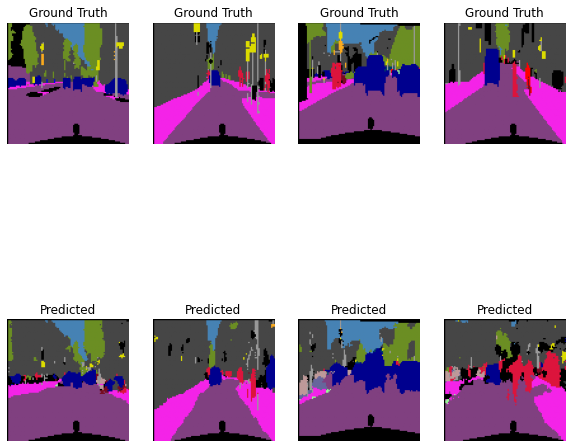

In [ ]:
fig = plt.figure(figsize = (10,10))

for i in range(11,15):
  ax = fig.add_subplot(2, n_images, i-10)
  visualization = visual_label(mask[i,:,:].cpu().numpy(),labels_used)
  ax.imshow(visualization)
  ax.set_title('Ground Truth')
  ax.axis('off')

  ax = fig.add_subplot(2, n_images, i-6)
  y_test = y_pred.permute(0,2,3,1)[i,:,:,:].cpu().numpy()
  visual_test = visual_label(np.argmax(y_test,axis=2),labels_used)
  ax.imshow(visual_test)
  ax.set_title('Predicted')
  ax.axis('off')